In [1]:
import sys, os
BIN = os.path.expanduser("../../../")
sys.path.append(BIN)

In [2]:
import numpy as np
from scipy.constants import m_p, c, e
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import math as m

from PyHEADTAIL.trackers.transverse_tracking import TransverseMap
from PyHEADTAIL.trackers.simple_long_tracking import LinearMap
import PyHEADTAIL.particles.generators as generators
import PyHEADTAIL.cobra_functions.stats as st


PyHEADTAIL v1.2.0-75-g4a904f5172-dirty




In [3]:
def test_transverse_map(n_macroparticles, linear_map, gamma = 3730.27):
    ax = np.array([-1.2, 2., 3.])
    ay = np.array([0.3, 2., 3.])
    bx = np.array([82., 90., 100.])
    by = np.array([45., 30, 80.])
    gx = (ax*ax + 1.) / bx
    gy = (ay*ay + 1.) / by
    print(gx)
    print(gy)
    dx = np.array([0.5, 5.3, 0.3])
    dy = np.array([0.2, -4.1, 2.09])
    #dx = dy = np.zeros(3)
    segments = np.linspace(0., C, num=4)
    
    # generate a map with the given parameters
    trans_map = TransverseMap(C, segments, ax, bx, dx, ay, by, dy, Q_x, Q_y)
    map_ = [m for m in trans_map]
    
    # generate a bunch matched to the alpha, beta and d of the first segment
    b = generate_bunch(n_macroparticles, ax[0], ay[0], bx[0], by[0], linear_map, dx[0], dy[0], gamma)
    
    def print_parameters(b, it):
        it = it % 3 #to make sure that after the last segment you access the first segment's parameters
        print('alphax: ' + str(ax[it]) + ' <---> ' + str(b.alpha_Twiss_x()))
        print('alphay: ' + str(ay[it]) + ' <---> ' + str(b.alpha_Twiss_y()))
        print('betax: ' + str(bx[it]) + ' <---> ' + str(b.beta_Twiss_x()))
        print('betay: ' + str(by[it]) + ' <---> ' + str(b.beta_Twiss_y()))
        print('gammax: ' + str(gx[it]) + ' <---> ' + str(b.gamma_Twiss_x()))
        print('gammay: ' + str(gy[it]) + ' <---> ' + str(b.gamma_Twiss_y()))
        print('dispx: ' + str(dx[it]) + ' <---> ' + str(b.dispersion_x()))
        print('dispy: ' + str(dy[it]) + ' <---> ' + str(b.dispersion_y()))
        print('epsnx: ' + str(3.75e-6) + ' <---> ' + str(b.epsn_x()))
        print('epsny: ' + str(3.75e-6) + ' <---> ' + str(b.epsn_y()))
        print('epsnz: ' + 'TODO' + ' <---> ' + str(b.epsn_z()))
        print('\n')
    
    print_parameters(b, 0) # matched to the first segment
    #track and check parameters!
    nturns = 3
    for n in xrange(nturns):
        for it,m in enumerate(map_):
            m.track(b)
            print_parameters(b, it+1)
    #check after the last segment           

            
    

In [4]:
def plot_disp_vs_alphabeta(N=10000, dx=20, gamma=1000):
    nsamples = 20
    n = 50
    alpha = np.linspace(-2., 2., n)
    beta = np.linspace(0.1, 50, n)
    
    adiff, bdiff = np.meshgrid(alpha, beta)
    ddiff = np.zeros(shape=(n,n))
    
    
    for i in range(n):
        for j in range(n):
            b = generate_bunch(N, adiff[j,i], adiff[j,i], bdiff[j,i], bdiff[j,i], LinearMap(alpha_0, C, Q_s), dx, dx, gamma)
            ddiff[j, i] = abs(dx - b.dispersion_x())
            
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(adiff, bdiff, ddiff, rstride=1, cstride=1, cmap='hot', linewidth=0, antialiased=False)
    ax.set_xlabel('alpha')
    ax.set_ylabel('beta')
    ax.set_zlabel('L1(dispx=' + str(dx) + ')')
    plt.title('L1 of disp_x error with gamma=' + str(gamma))
    plt.show()
            
            
            
            

In [5]:

def plot_params_vs_gamma(ax=0.5, ay=-1.1, bx=20, by=80, dx=5, dy=-4, N=50000):
    nsamples = 25
    
    # first a scan of a big range of gammas with large spacing
    plt.plot(0, 0)
    gammas = range(2, 4000, 50)
    ax_L1 = np.zeros(len(gammas))
    ax_L1_dE = np.zeros(len(gammas))
    bx_L1 = np.zeros(len(gammas))
    bx_L1_dE = np.zeros(len(gammas))
    dx_L1 = np.zeros(len(gammas))
    dx_L1_dE = np.zeros(len(gammas))
    for i, gamma in enumerate(gammas):
        for s in range(nsamples):
            b = generate_bunch(N, ax, ay, bx, by, LinearMap(alpha_0, C, Q_s), dx, dy, gamma)
            ax_L1_dE[i] += abs(ax - b.alpha_Twiss_x_dE())
            bx_L1_dE[i] += abs(bx - b.beta_Twiss_x_dE())
            dx_L1_dE[i] += abs(dx - b.dispersion_x_dE())
            ax_L1[i] += abs(ax - b.alpha_Twiss_x())
            bx_L1[i] += abs(bx - b.beta_Twiss_x())
            dx_L1[i] += abs(dx - b.dispersion_x())
        ax_L1_dE[i] /= nsamples
        dx_L1_dE[i] /= nsamples
        bx_L1_dE[i] /= nsamples
        ax_L1[i] /= nsamples
        dx_L1[i] /= nsamples
        bx_L1[i] /= nsamples

        #print(ax_L2[i])
    axdp, = plt.plot(gammas, ax_L1, label='dp')
    axdE, = plt.plot(gammas, ax_L1_dE, label='dE')
    plt.legend(handles=[axdp, axdE])
    plt.xlabel('gamma')
    plt.ylabel('<L1 error> of ' + str(nsamples) + ' samples')
    plt.title('alpha_x: ' + str(ax) )
    plt.show()
    
    bxdp, = plt.plot(gammas, bx_L1, label='dp')
    bxdE, = plt.plot(gammas, bx_L1_dE, label='dE')
    plt.xlabel('gamma')
    plt.ylabel('<L1 error> of ' + str(nsamples) + ' samples')
    plt.legend(handles=[bxdp, bxdE])
    plt.title('beta_x: ' + str(bx))
    plt.show()
    
    dxdp, = plt.plot(gammas, dx_L1, label='dp')
    dxdE, = plt.plot(gammas, dx_L1_dE, label='dE')
    plt.xlabel('gamma')
    plt.ylabel('<L1 error> of ' + str(nsamples) + ' samples')
    plt.legend(handles=[dxdp, dxdE])
    plt.title('disp_x: ' + str(dx))
    plt.yscale('log')
    plt.show()
            
            
            
    

In [6]:
def generate_bunch(n_macroparticles, alpha_x, alpha_y, beta_x, beta_y, linear_map, dispx, dispy, gamma = 3730.27):
    # generate a alpha=0, beta=1 bunch first
    # then transform...
    intensity = 1.05e11
    sigma_z = 0.59958
    gamma_t = 1. / np.sqrt(alpha_0)
    p0 = np.sqrt(gamma**2 - 1) * m_p * c

    beta_z = (linear_map.eta(dp=0, gamma=gamma) * linear_map.circumference / 
              (2 * np.pi * linear_map.Qs))

    epsn_x = 3.75e-6 # [m rad]
    epsn_y = 3.75e-6 # [m rad]
    epsn_z = 4 * np.pi * sigma_z**2 * p0 / (beta_z * e)
    
    bunch = generators.Gaussian6DTwiss(
        macroparticlenumber=n_macroparticles, intensity=intensity, charge=e,
        gamma_reference=gamma, mass=m_p, circumference=C,
        alpha_x=0., beta_x=1., epsn_x=epsn_x,
        alpha_y=0., beta_y=1., epsn_y=epsn_y,
        beta_z=beta_z, epsn_z=epsn_z).generate()
    
    # Scale to correct beta and alpha
    xx = bunch.x.copy()
    yy = bunch.y.copy()
    bunch.x *= np.sqrt(beta_x)
    bunch.xp = -alpha_x/np.sqrt(beta_x) * xx + 1./np.sqrt(beta_x) * bunch.xp
    
    bunch.y *= np.sqrt(beta_y)
    bunch.yp = -alpha_y/np.sqrt(beta_y) * yy + 1./np.sqrt(beta_y) * bunch.yp
    
    
    
    bunch.x += dispx * bunch.dp
    bunch.y += dispy * bunch.dp
    
    return bunch

In [7]:
def plot_phase_space(beam, direction):
    plt.figure()
    u = getattr(beam, direction[0])
    up = getattr(beam, direction[1])
    plt.scatter(u, up)
    minimum = min(min(u),min(up))
    maximum =  max(max(u), max(up))
    plt.ylim([minimum, maximum])
    plt.xlim([minimum, maximum])
    plt.xlabel(direction[0])
    plt.ylabel(direction[1])
    plt.show()

In [8]:
# Generate a bunch with the given optics and compare them to the statistically computed parameters
def compute_statistical_beam_optics(alphax, alphay, betax, betay, long_map, dispx, dispy, gamma=3000):
    b = generate_bunch(n_macroparticles, alphax, alphay, betax, betay, long_map, dispx, dispy, gamma)
    gammax = (1. + alphax**2)/betax
    gammay = (1. + alphay**2)/betay
    print('Compare the nominal and the statistically computed quantities from the beam')
    print('nominal: <---> statistical:')
    print('alphax: ' + str(alphax) + ' <---> ' + str(b.alpha_Twiss_x()))
    print('alphax_dE: ' + str(alphax) + ' <---> ' + str(b.alpha_Twiss_x_dE()))
    print('alphay: ' + str(alphay) + ' <---> ' + str(b.alpha_Twiss_y()))
    print('alphay_dE: ' + str(alphay) + ' <---> ' + str(b.alpha_Twiss_y_dE()))
    print('betax: ' + str(betax) + ' <---> ' + str(b.beta_Twiss_x()))
    print('betax_dE: ' + str(betax) + ' <---> ' + str(b.beta_Twiss_x_dE()))
    print('betay: ' + str(betay) + ' <---> ' + str(b.beta_Twiss_y()))
    print('betay_dE: ' + str(betay) + ' <---> ' + str(b.beta_Twiss_y_dE()))
    print('gammax: ' + str(gammax) + ' <---> ' + str(b.gamma_Twiss_x()))
    print('gammax_dE: ' + str(gammax) + ' <---> ' + str(b.gamma_Twiss_x_dE()))
    print('gammay: ' + str(gammay) + ' <---> ' + str(b.gamma_Twiss_y()))
    print('gammay_dE: ' + str(gammay) + ' <---> ' + str(b.gamma_Twiss_y_dE()))
    print('dispx: ' + str(dispx) + ' <---> ' + str(b.dispersion_x()))
    print('dispx_dE: ' + str(dispx) + ' <---> ' + str(b.dispersion_x_dE()))
    print('dispy: ' + str(dispy) + ' <---> ' + str(b.dispersion_y()))
    print('dispy_dE: ' + str(dispy) + ' <---> ' + str(b.dispersion_y_dE()))

    

In [9]:
def plot_histogram(measurements, exact_value, title="Dummy"):
    plt.hist(measurements)
    plt.axvline(measurements.mean(), color='r', linestyle='dashed', linewidth=2)
    plt.axvline(exact_value, color='g', linewidth=2)
    plt.title(title)
    plt.xlabel('Value')
    plt.ylabel('# observations')
    m = mpatches.Patch(color='red', label='mean')
    ex = mpatches.Patch(color='green', label='input')

    plt.legend(handles=[m, ex])
    plt.show()


In [10]:
def compute_distribution_beam_optics(alphax, alphay, betax, betay, long_map, dispx, dispy, gamma=3000):
    nsamples = 100
    stat_betax = np.zeros(nsamples)
    stat_betay = np.zeros(nsamples)
    stat_alphax = np.zeros(nsamples)
    stat_alphay = np.zeros(nsamples)
    stat_dispx = np.zeros(nsamples)
    stat_dispy = np.zeros(nsamples)
    stat_betax_dE = np.zeros(nsamples)
    stat_betay_dE = np.zeros(nsamples)
    stat_alphax_dE = np.zeros(nsamples)
    stat_alphay_dE = np.zeros(nsamples)
    stat_dispx_dE = np.zeros(nsamples)
    stat_dispy_dE = np.zeros(nsamples)
    for i in xrange(nsamples):
        b = generate_bunch(n_macroparticles, alphax, alphay, betax, betay, long_map, dispx, dispy,gamma)
        stat_betax[i] = b.beta_Twiss_x()
        stat_betay[i] = b.beta_Twiss_y()
        stat_dispx[i] = b.dispersion_x()
        stat_dispy[i] = b.dispersion_y()
        stat_alphax[i] = b.alpha_Twiss_x()
        stat_alphay[i] = b.alpha_Twiss_y()
        stat_betax_dE[i] = b.beta_Twiss_x()
        stat_betay_dE[i] = b.beta_Twiss_y()
        stat_dispx_dE[i] = b.dispersion_x()
        stat_dispy_dE[i] = b.dispersion_y()
        stat_alphax_dE[i] = b.alpha_Twiss_x()
        stat_alphay_dE[i] = b.alpha_Twiss_y()
    plot_histogram(stat_betax, betax, 'beta_x')
    plot_histogram(stat_betax_dE, betax, 'beta_x_dE')
    plot_histogram(stat_betay, betay, 'beta_y')
    plot_histogram(stat_betay_dE, betay, 'beta_y_dE')
    plot_histogram(stat_alphax, alphax, 'alpha_x')
    plot_histogram(stat_alphax_dE, alphax, 'alpha_x_dE')
    plot_histogram(stat_alphay, alphay, 'alpha_y')
    plot_histogram(stat_alphay_dE, alphay, 'alpha_y_dE')
    plot_histogram(stat_dispx, dispx, 'disp_x')
    plot_histogram(stat_dispx_dE, dispx, 'disp_x_dE')
    plot_histogram(stat_dispy, dispy, 'disp_y')
    plot_histogram(stat_dispy_dE, dispy, 'disp_y_dE')

    plt.show()


In [11]:
# Basic simulation parameters
n_turns = 10
n_segments = 2
n_macroparticles = 100000

Q_x = 64.28
Q_y = 59.31
Q_s = 0.0020443

C = 26658.883
R = C / (2.*np.pi)

alpha_0 = [0.0003225]
long_map = LinearMap(alpha_0, C, Q_s)

In [12]:
alphax = 1.5
alphay = -2
betax = 1.4
betay = 40
dispx = 3
dispy = 5
beam = generate_bunch(n_macroparticles, alphax, alphay, betax, betay, long_map, dispx, dispy, gamma = 479.)
print(beam._dE())
print(beam.alpha_Twiss_x_dE())
print(beam.alpha_Twiss_y_dE())

print(beam.alpha_Twiss_x())
print(beam.alpha_Twiss_y())

[ -4.06146798e-12  -4.12286500e-11  -2.60226443e-11 ...,  -1.78375860e-11
   8.05993464e-11   4.05951798e-11]
1.50547816708
-1.99884619035
1.49718332249
-1.9973960542


In [13]:
%matplotlib inline
alphax = 0.5
alphay = -1.7
betax = 90
betay = 40
dispx = 4.3
dispy = -3.
gamma = 1.1
beam2 = generate_bunch(n_macroparticles, alphax, alphay, betax, betay, long_map, dispx, dispy, gamma)
print('mass: ' + str(beam2.mass))
print('c**2: ' + str(c**2))
print('E0: ' + str(beam2.gamma*beam2.mass*c*c))
print('<dE2>: ' + str(np.mean(beam2._dE()**2)))
print('<dp2>: ' + str(np.mean(beam2.dp**2)))
compute_statistical_beam_optics(alphax, alphay, betax, betay, long_map, dispx, dispy, gamma)

compute_distribution_beam_optics(alphax, alphay, betax, betay, long_map, dispx, dispy, gamma)


mass: 1.672621777e-27
c**2: 8.98755178737e+16
E0: 1.65360523256e-10
<dE2>: 1.00737979291e-34
<dp2>: 1.22309927992e-13
Compare the nominal and the statistically computed quantities from the beam
nominal: <---> statistical:
alphax: 0.5 <---> 0.497294372059
alphax_dE: 0.5 <---> 0.497294368413
alphay: -1.7 <---> -1.69629766076
alphay_dE: -1.7 <---> -1.69629771015
betax: 90 <---> 90.2386881798
betax_dE: 90 <---> 90.2386886544
betay: 40 <---> 39.8620467036
betay_dE: 40 <---> 39.8620476988
gammax: 0.0138888888889 <---> 0.0138222498314
gammax_dE: 0.0138888888889 <---> 0.0138222497185
gammay: 0.09725 <---> 0.0972711156239
gammay_dE: 0.09725 <---> 0.0972711173982
dispx: 4.3 <---> 60.7659379734
dispx_dE: 4.3 <---> 60.5439360153
dispy: -3.0 <---> -122.41588752
dispy_dE: -3.0 <---> -122.126665575


KeyboardInterrupt: 

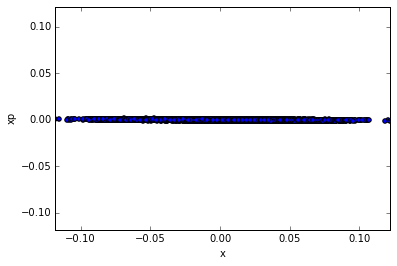

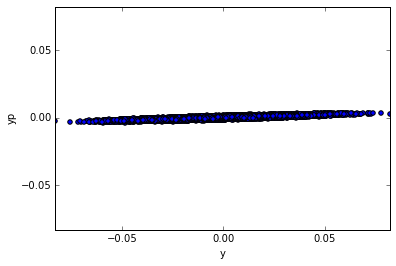

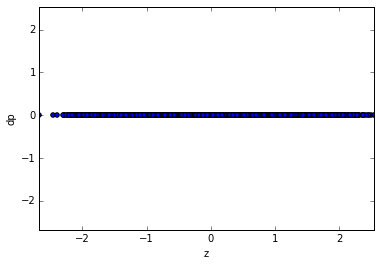

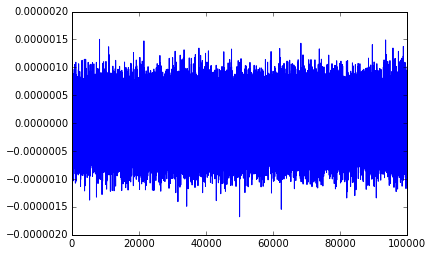

In [14]:
%matplotlib inline
plot_phase_space(beam2, ['x', 'xp'])
plot_phase_space(beam2, ['y', 'yp'])
plot_phase_space(beam2, ['z', 'dp'])
plt.plot(beam2.dp)
plt.show()

In [16]:
#test_transverse_map(50000, long_map, 3000) # here alphas & betas go crazy, disp correct
test_transverse_map(100000, long_map, 4000) # here alphas and disp are wrong..., beta correct. disp correct for small betas!

[ 0.0297561   0.05555556  0.1       ]
[ 0.02422222  0.16666667  0.125     ]

*** PyHEADTAIL WARNING! Non-zero dispersion; ensure the beam has been "blown-up" accordingly upon creation!
alphax: -1.2 <---> -1.2021729237
alphay: 0.3 <---> 0.300573558169
betax: 82.0 <---> 297.0525933
betay: 45.0 <---> 79.9063909609
gammax: 0.029756097561 <---> 0.0298308579934
gammay: 0.0242222222222 <---> 0.0242364489416
dispx: 0.5 <---> 0.498743820471
dispy: 0.2 <---> 0.201122868007
epsnx: 3.75e-06 <---> 3.73832073605e-06
epsny: 3.75e-06 <---> 3.74520594355e-06
epsnz: TODO <---> 84.7972990012


alphax: 2.0 <---> 2.03000122485
alphay: 2.0 <---> 2.06103745379
betax: 90.0 <---> 24817.1098714
betay: 30.0 <---> 14979.9353188
gammax: 0.0555555555556 <---> 0.0564007719515
gammay: 0.166666666667 <---> 0.171821583881
dispx: 5.3 <---> 5.30160505425
dispy: -4.1 <---> -4.09867235254
epsnx: 3.75e-06 <---> 3.67434607202e-06
epsny: 3.75e-06 <---> 3.63226634569e-06
epsnz: TODO <---> 84.7972990012


alphax: 3.0 <---> 2.99

In [17]:
# dispersion checks..
N = 10
np.random.seed(0)
x = np.random.normal(0, 1, N)
xp = np.random.normal(0, 1, N)
y = np.random.normal(0, 1, N)
yp = np.random.normal(0, 1, N)
dp_zeros = np.zeros(N)
dp = np.random.normal(1, 1e-5, N)
#dp = np.ones(N)

print(np.sum(np.multiply(dp,dp)))
mean_dp2 = st.mean(np.multiply(dp,dp))
print(mean_dp2)
# add dispersion in x
dx = 10
dy = 3000
x = x + dx*dp
y = y + dy*dp

print(np.cov(x,xp))
print(st.cov(x,xp))
print(st.cov_onepass(x,xp))

print('\ndispersions')
print('\n x')
print(st.dispersion(x, dp))
print(st.dispersion__(x,dp))
print('\n y')
print(st.dispersion(y, dp))
print(st.dispersion__(y,dp))
print((np.sum(np.multiply(x,dp))))
#

9.9998905268
0.99998905268
[[ 1.03921515  0.05185737]
 [ 0.05185737  0.50385302]]
0.0518573743361
0.0518573743361

dispersions

 x
10.7380297813
4.67636577106
2.30257414561
10.7380297813

 y
3000.18989755
10.3090050104
2.30257414561
3000.18989755
107.379122287


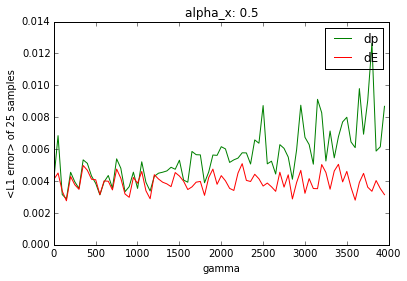

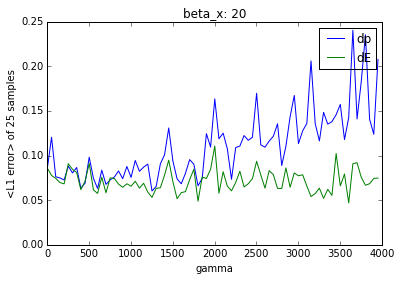

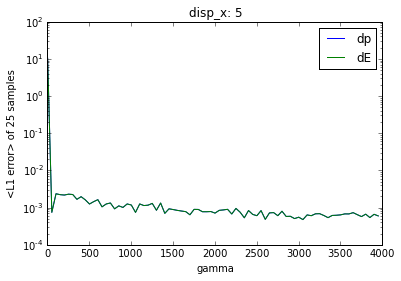

In [14]:
# alpha checks...
%matplotlib inline
plot_params_vs_gamma()

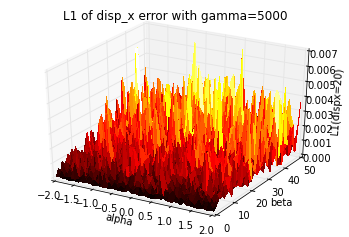

In [15]:
plot_disp_vs_alphabeta(gamma=5000)